# Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cleaning" data-toc-modified-id="Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cleaning</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Categorical-features" data-toc-modified-id="Categorical-features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Categorical features</a></span></li><li><span><a href="#Binary-features" data-toc-modified-id="Binary-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Binary features</a></span></li><li><span><a href="#Numerical-features" data-toc-modified-id="Numerical-features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Numerical features</a></span></li><li><span><a href="#preprocessing-pipe" data-toc-modified-id="preprocessing-pipe-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>preprocessing pipe</a></span></li><li><span><a href="#output-processing" data-toc-modified-id="output-processing-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>output processing</a></span></li><li><span><a href="#regression-model" data-toc-modified-id="regression-model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>regression model</a></span></li></ul></li><li><span><a href="#Training-and-evaluation" data-toc-modified-id="Training-and-evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training and evaluation</a></span><ul class="toc-item"><li><span><a href="#Mean-regressor-baseline" data-toc-modified-id="Mean-regressor-baseline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Mean regressor baseline</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cross validation</a></span></li><li><span><a href="#Valid-evaluation" data-toc-modified-id="Valid-evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Valid evaluation</a></span></li><li><span><a href="#Train-evaluation" data-toc-modified-id="Train-evaluation-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Train evaluation</a></span></li><li><span><a href="#Error-analysis" data-toc-modified-id="Error-analysis-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Error analysis</a></span><ul class="toc-item"><li><span><a href="#over-estimated" data-toc-modified-id="over-estimated-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>over estimated</a></span></li><li><span><a href="#under-estimated" data-toc-modified-id="under-estimated-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>under estimated</a></span></li></ul></li></ul></li><li><span><a href="#export-model" data-toc-modified-id="export-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>export model</a></span></li></ul></div>

In [1]:
from pandas import DataFrame, read_csv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, LabelEncoder, PolynomialFeatures,
                                   OneHotEncoder, OrdinalEncoder, FunctionTransformer,
                                   PowerTransformer)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np

In [2]:
SEED=42

In [3]:
#!../scrapper/scrapper.py csv --file ./fulltrain.csv

In [4]:
df_full = read_csv('../fulltrain.csv', index_col='idannonce')

## Cleaning

In [5]:
df_full.columns

Index(['typedebien', 'codepostal', 'codeinsee', 'ville', 'idtypechauffage',
       'idtypecuisine', 'si_balcon', 'nb_chambres', 'nb_pieces', 'si_sdbain',
       'si_sdEau', 'nb_photos', 'etage', 'prix', 'surface', 'dpeL', 'dpeC',
       'description', 'id'],
      dtype='object')

In [6]:
chauffageNArows = df_full['idtypechauffage'] == 0
df_full.loc[chauffageNArows,'idtypechauffage'] = np.nan

In [7]:
codpostal33rows = df_full['codepostal'] == 33
df_full.loc[codpostal33rows,'codepostal'] = 33000

In [8]:
cuisineNArows = df_full['idtypecuisine'] == 0
df_full.loc[cuisineNArows,'idtypecuisine'] = np.nan

In [9]:
df_full['surface'] = df_full['surface'].str.replace(",", ".").astype(float)

In [10]:
nonzero_surface = df_full['surface'] != 0
df_full = df_full.loc[nonzero_surface,:]

In [11]:
notcolocation_rows = ~(df_full['description'].str.contains("([Cc]oloc)")).astype('Bool')
df_full = df_full.loc[notcolocation_rows,:]

C:\Users\utilisateur\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [12]:
df_full = df_full.drop(['id','ville', 'codeinsee','nb_photos', 'dpeL', 'description'], axis=1)

In [13]:
df_full.columns

Index(['typedebien', 'codepostal', 'idtypechauffage', 'idtypecuisine',
       'si_balcon', 'nb_chambres', 'nb_pieces', 'si_sdbain', 'si_sdEau',
       'etage', 'prix', 'surface', 'dpeC'],
      dtype='object')

In [14]:
df_full.shape

(985, 13)

In [15]:
#df_full.to_csv('dataset_clean.csv', header=True, index_label=id)

## Pipeline

In [16]:
#categoricals = ['typedebien', 'ville','idtypechauffage', 'idtypecuisine','codepostal','codeinsee']
categoricals = ['typedebien', 'idtypechauffage', 'idtypecuisine', 'codepostal']
binaries = ['si_balcon','si_sdbain','si_sdEau']
#numericals = ['nb_chambres', 'nb_pieces', 'nb_photos', 'etage', 'surface', 'dpeC']
numericals = ['nb_chambres', 'nb_pieces', 'etage', 'surface', 'dpeC']
text = ['description']

### Categorical features

In [17]:
for col in categoricals:
    print(df_full[col].unique())

['Appartement' 'Maison / Villa']
['gaz collectif' 'individuel électrique radiateur' '0'
 'individuel électrique' 'individuel' 'individuel gaz radiateur' 'central'
 'individuel gaz' 'central radiateur' 'électrique radiateur' 'gaz'
 'électrique' 'gaz radiateur' 'gaz collectif radiateur'
 'individuel radiateur' 'central électrique radiateur'
 'central électrique' 'climatisation réversible' 'gaz collectif mixte'
 'central électrique mixte' 'climatisation réversible individuelle'
 'individuel fuel radiateur' 'radiateur' 'central fuel']
['0' 'aucune' 'américaine' 'équipée' 'coin cuisine' 'américaine équipée'
 'coin cuisine équipé' 'séparée équipée' 'séparée']
[33000 33700 33140 33400 33600 33150 33300 33310 33800 33130 33200 33100
 33520 33880]


In [18]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

### Binary features

In [19]:
for col in binaries:
    print(df_full[col].unique())

[0 1]
[1 0]
[0 1]


In [20]:
binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

### Numerical features

In [21]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    #('poly', PolynomialFeatures(degree=2)),
    ('power',  PowerTransformer()),
    #('scaler', StandardScaler())
])

### preprocessing pipe

In [22]:
preprocess_pipe = ColumnTransformer([
    ('cat', categorical_pipe, categoricals),
    ('num', numerical_pipe, numericals),
    ('ord', binary_pipe, binaries)
])

### output processing

In [23]:
output_pipe = Pipeline([
    ('log', FunctionTransformer(func=np.log, inverse_func=np.exp)),
    ('scaler', StandardScaler())
])

### regression model

In [24]:
rdgRegressor = Ridge()
xgbRegressor = XGBRegressor(booster="gbtree")
svrRegressor = SVR(kernel='rbf', C=0.8)

In [25]:
model = Pipeline([
    ('pre', preprocess_pipe),
    ('reg', svrRegressor)
])

In [26]:
full_pipe = TransformedTargetRegressor(regressor=model, transformer=output_pipe)

In [27]:
dump(full_pipe,'pipeline-model.joblib')

['pipeline-model.joblib']

In [28]:
from sklearn.model_selection import train_test_split
target_column = "prix"

X_fulltrain = df_full.drop(target_column, axis=1)
y_fulltrain = df_full[target_column]

X_train, X_valid, y_train, y_valid = train_test_split(X_fulltrain, y_fulltrain, test_size=0.2, random_state=SEED)

## Training and evaluation

In [29]:
full_pipe.fit(X_train,y_train);

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_tra

### Mean regressor baseline

In [30]:
y_valid_pred = [np.mean(y_train)] * y_valid.shape[0]
r2 = r2_score(y_valid, y_valid_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmsle = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_valid_pred)))
msle = (mean_squared_error(np.log(y_valid), np.log(y_valid_pred)))
mape = np.mean(np.abs((y_valid-y_valid_pred)/y_valid))
print(f'r2 = {r2}\nrmse = {rmse}\nmsle = {msle}\nrmsle = {rmsle}\nmape = {mape}')

r2 = -0.017899090662610417
rmse = 408.044461132066
msle = 0.16392636904079003
rmsle = 0.4048782150731131
mape = 0.3335433792066622


### Cross validation

In [31]:
scores = cross_val_score(full_pipe, X_fulltrain, y=y_fulltrain, cv=10)
print(f'mean R2 = {np.mean(scores)} +/- {np.std(scores)}')
scores

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_tra

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_tra

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_tra

mean R2 = 0.7227511484201592 +/- 0.08402403443957587


C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([0.64032801, 0.58846633, 0.84637123, 0.69617311, 0.74839694,
       0.66716084, 0.80897505, 0.63943822, 0.77486269, 0.81733907])

### Valid evaluation

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


r2 = 0.7738038865608339
rmse = 192.3524370629757
msle = 0.03883850458178337
rmsle = 0.197074870497949
mape = 0.1500983981390996


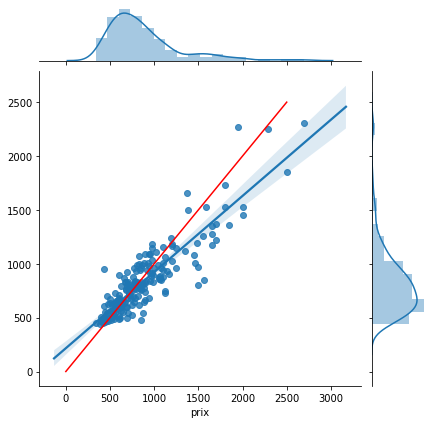

In [32]:
y_valid_pred = full_pipe.predict(X_valid)
valid_r2 = r2_score(y_valid, y_valid_pred)
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
valid_rmsle = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_valid_pred)))
valid_msle = (mean_squared_error(np.log(y_valid), np.log(y_valid_pred)))
valid_mape = np.mean(np.abs((y_valid-y_valid_pred)/y_valid))
print(f'r2 = {valid_r2}\nrmse = {valid_rmse}\nmsle = {valid_msle}\nrmsle = {valid_rmsle}\nmape = {valid_mape}')
grid = sns.JointGrid(y_valid, y_valid_pred)
grid = grid.plot(sns.regplot, sns.distplot)
grid.ax_joint.plot([0,2500], [0,2500], 'r');

### Train evaluation

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


r2 = 0.7194982313365115
rmse = 204.0539545569429
msle = 0.032027236404319204
rmsle = 0.17896155007240858
mape = 0.12400450422060205


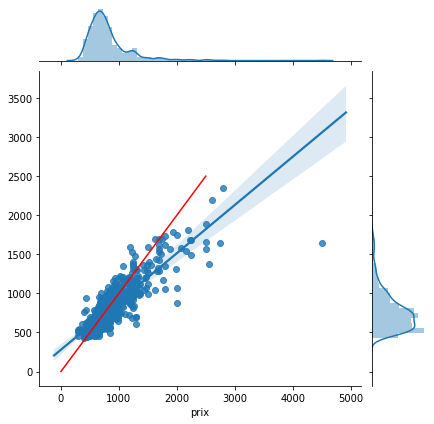

In [33]:
y_train_pred = full_pipe.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmsle = np.sqrt(mean_squared_error(np.log(y_train), np.log(y_train_pred)))
msle = (mean_squared_error(np.log(y_train), np.log(y_train_pred)))
mape = np.mean(np.abs((y_train-y_train_pred)/y_train))
print(f'r2 = {r2}\nrmse = {rmse}\nmsle = {msle}\nrmsle = {rmsle}\nmape = {mape}')
grid = sns.JointGrid(y_train, y_train_pred)
grid = grid.plot(sns.regplot, sns.distplot)
grid.ax_joint.plot([0,2500], [0,2500], 'r');

### Error analysis

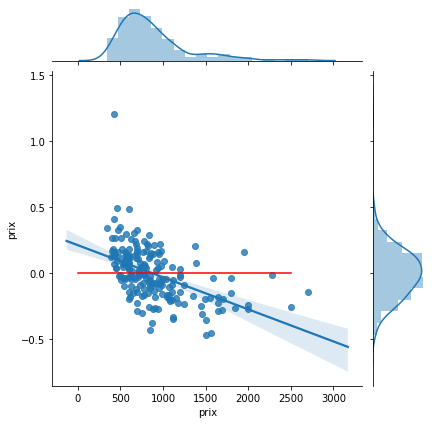

In [34]:
grid = sns.JointGrid(y_valid, (y_valid_pred-y_valid)/y_valid )
grid = grid.plot(sns.regplot, sns.distplot)
grid.ax_joint.plot([0,2500], [0,0], 'r');

#### over estimated

In [35]:
errors = ((y_valid_pred-y_valid)/y_valid) > 0.5
error_df = X_valid.loc[errors,:]
error_df.loc[errors,'prix'] = y_valid.loc[errors]
error_df.loc[errors,'pred'] = y_valid_pred[errors]
error_df

C:\Users\utilisateur\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\utilisateur\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,typedebien,codepostal,idtypechauffage,idtypecuisine,si_balcon,nb_chambres,nb_pieces,si_sdbain,si_sdEau,etage,surface,dpeC,prix,pred
idannonce,,,,,,,,,,,,,,
155430409,Appartement,33600,individuel gaz radiateur,équipée,0,0,2,1,0,0,121.0,215,430,948.338566


#### under estimated

In [36]:
errors = (y_valid_pred-y_valid)/y_valid < -0.4
error_df = X_valid.loc[errors,:]
error_df.loc[errors,'prix'] = y_valid.loc[errors]
error_df.loc[errors,'pred'] = y_valid_pred[errors]
error_df

,typedebien,codepostal,idtypechauffage,idtypecuisine,si_balcon,nb_chambres,nb_pieces,si_sdbain,si_sdEau,etage,surface,dpeC,prix,pred
idannonce,,,,,,,,,,,,,,
152551285,Appartement,33000,individuel électrique radiateur,équipée,0,1,2,0,1,2,45.3,0,1500,802.407285
145612541,Appartement,33000,central,séparée,0,1,2,0,1,3,55.0,0,1560,852.722881
155587787,Appartement,33800,0,coin cuisine,1,0,1,1,0,2,23.0,80,849,482.037229


## export model

In [37]:
from os import getcwd, mkdir, path
now =  datetime.now()
model_file_name = 'realestate-model-' + now.strftime("%Y-%d-%m-%Hh%Ms") + '-rmsle-' + '{:.3f}'.format(valid_rmsle) + '.pkl'
base_dir = path.dirname(getcwd())
model_dir = base_dir + '/models'
if not path.exists(model_dir):
    mkdir(model_dir)
model_path = path.join(model_dir, model_file_name)
model_path

'C:\\Users\\utilisateur\\Documents\\GitHub\\realestate-guillaume-nicos-pierre-silvia/models\\realestate-model-2020-18-03-16h21s-rmsle-0.197.pkl'

In [38]:
dump(full_pipe, model_path)

['C:\\Users\\utilisateur\\Documents\\GitHub\\realestate-guillaume-nicos-pierre-silvia/models\\realestate-model-2020-18-03-16h21s-rmsle-0.197.pkl']

In [39]:
from glob import glob
max(glob(path.join(model_dir, 'realestate-model-*.pkl')))

'C:\\Users\\utilisateur\\Documents\\GitHub\\realestate-guillaume-nicos-pierre-silvia/models\\realestate-model-2020-18-03-16h21s-rmsle-0.197.pkl'

## Export metrics and insertion in the BDD

In [40]:
import mysql.connector
def connectToDatabase():
    return mysql.connector.connect(user='realestate', password='realestate',
                              host='127.0.0.1',
                              database='realestate')
def createCursor(cnx):
    return cnx.cursor(dictionary=True)
def insertModelQuery(model_name,r2,rmse,rmsle, msle, mape):
    return ("INSERT INTO `models` (`model_name`, `r2`,`rmse`, `rmsle`,`msle`, `mape`) VALUES ('{}', '{}','{}', '{}','{}', '{}')".format(model_name,r2,rmse,rmsle, msle, mape))
def closeCursor(cursor):
    cursor.close()
def disconnectDatabase(cnx):
    cnx.close()

In [41]:
import glob

cnx = connectToDatabase()
for file in glob.glob("*.pkl"):
    cursor = createCursor(cnx)
    cursor.execute(insertModelQuery(model_file_name,r2,rmse,rmsle, msle, mape))
    cnx.commit()
    closeCursor(cursor)
disconnectDatabase(cnx)